In [1]:
import pandas as pd

In [6]:
test = pd.read_csv('/Users/yifeisun/Desktop/Translation_Test/test_table.csv')

In [7]:
user = pd.read_csv('/Users/yifeisun/Desktop/Translation_Test/user_table.csv')

In [8]:
test.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [9]:
user.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


### 1) Confirm that the test is actually negative. That is, it appears that the old version of the sitewith just one translation across Spain and LatAm performs better

##### 1. ABTest 的一个重要假设就是 the only difference/change during the test shuould be the thing we are testing.
##### 2. 这就说明着控制组和对照组的抽样分布应该是comparable的，不能带有bias

### So, First we are going to check that test and control distributions are similar before doing the statistical test. 

In [19]:
#let's check that data makes sense
#The id should be unique
print(test['user_id'].nunique() == len(test['user_id']))

True


In [21]:
print(user['user_id'].nunique() == len(user['user_id']))

True


In [22]:
#the difference btw test and user id
print(len(user['user_id']) - len(test['user_id']))

-454


In [23]:
# the result shows there are some user missing in the User table,
# and we can get ride of this now because the amount is small which won't affact result, 
# but this is one problem we need to check in future work
data = test.merge(user,on='user_id')
data['date'] = pd.to_datetime(data['date'])
data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [25]:
print(data.describe(include='all'))

               user_id                 date  source  device browser_language  \
count    452867.000000               452867  452867  452867           452867   
unique             NaN                    5       3       2                3   
top                NaN  2015-12-04 00:00:00     Ads     Web               ES   
freq               NaN               141024  181693  251316           377160   
first              NaN  2015-11-30 00:00:00     NaN     NaN              NaN   
last               NaN  2015-12-04 00:00:00     NaN     NaN              NaN   
mean     499944.805166                  NaN     NaN     NaN              NaN   
std      288676.264784                  NaN     NaN     NaN              NaN   
min           1.000000                  NaN     NaN     NaN              NaN   
25%      249819.000000                  NaN     NaN     NaN              NaN   
50%      500019.000000                  NaN     NaN     NaN              NaN   
75%      749543.000000                  

### Second, let’s make sure it is true Spain converts much better than LatAm countries. 

In [28]:
data_conversion = data.query('test == 0').groupby(data['country'])['conversion'].mean()
data_conversion.sort_values(ascending=False)

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

In [29]:
# the result shows it is TRUE spain converts more than other countries

In [38]:
#a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.
from scipy import stats
data = data.query('country != "Spain"')
print(data.groupby('test')['conversion'].mean())

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [39]:
ttest_result = stats.ttest_ind(data[data['test'] == 0]['conversion'],data[data['test'] == 1]['conversion'],equal_var=False)

In [40]:
print(ttest_result.pvalue)

1.9289178577799033e-13


In [41]:
print(ttest_result.statistic)

7.353895203080277


#### The result looks correct. Mmh…control users are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are: 

1) We didn’t collect enough data 

2) Some bias has been introduced in the experiment so that test/control people are not really random 


### First we are going to check the conversion rate day by day for 0 and 1 group. To see if there is anything wrong data.

/Users/yifeisun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


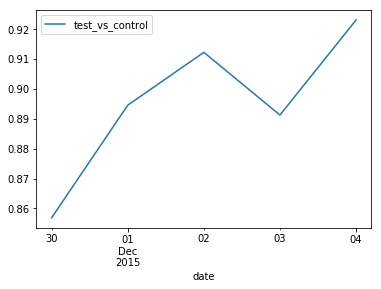

In [44]:
import matplotlib.pyplot as plt
  
#compare test and control conversion rate by day and plot it
data_test_by_day = data.groupby("date")["conversion"].agg({
"test_vs_control": lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()
}).plot()
plt.show()

In [45]:
# The plot shows the conversion rate for testing group is constantly worse than the control group (the ratio is < 1)

### Second, the most important. We are going to check the A/B Test Randomization.

In [51]:
# First, check the distribution for sources
data_sources = data.groupby('source')["test"].agg({"frequency_test_0": lambda x: len(x[x==0]), 
"frequency_test_1": lambda x: len(x[x==1])})
print(data_sources/data_sources.sum())

        frequency_test_0  frequency_test_1
source                                    
Ads             0.401228          0.400641
Direct          0.200949          0.199500
SEO             0.397823          0.399858


/Users/yifeisun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
#这个是test的一种方法，但是如果每个variable都这样做的话，就会非常麻烦。
#所以在看数据之前有没有潜在的联系的时候，我们把这个问题转为了一个ML问题

#### 1. Get rid of the conversion variable for now. We don’t care about it here. We are just checking if the two user distributions are the same. This is before we check conversion rate for the groups


#### 2. Use the variable test as our label. Try to build a model that manages to separate the users whose test value is 0 vs those whose test value is 1. If randomization worked well, this will be impossible because the two groups are exactly the same. If all variable relative frequencies were the same as for source, no model would be able to separate test == 1 vs test == 0. If randomization did not work well, the model will manage to use a given variable to separate the two groups. 


#### 3. As a model, pick a decision tree. This will allow you to clearly see which variable (if any) is used for the split. That’s where randomization failed. 

In [54]:
#这后面的部分有一点复杂，等到后来在看